In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random 
import torch
from torch.autograd import Variable
import math


In [169]:
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
labels=labels.astype(int)
labels[labels!=0]=-1
labels[labels==0]=1
labels[labels==-1]=0


10000


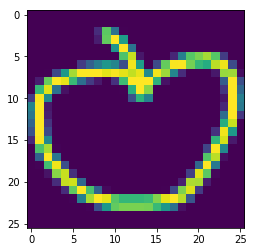

In [170]:
apples=images[labels==1]
print(len(apples))
plt.imshow(apples[0])


In [171]:
shape_images_flat=(images.shape[0],images.shape[1]*images.shape[2])
images_flat=np.ndarray(shape=shape_images_flat)
for index in range(len(images)):
    images_flat[index]=images[index].flat
images_flat=(images_flat-images_flat.mean())/images.std()

In [172]:
train_images=images_flat[0:40000]
train_labels=labels[0:40000]

validation_images=images_flat[40000:45000]
validation_labels=labels[40000:45000]

test_images=images_flat[45000:50000]
test_labels=labels[45000:50000]

In [173]:
def sigmoid(x):  
    return math.exp(-np.logaddexp(0, -x))

In [174]:
def accuracy_2(y, y_hat):
    """Compute accuracy.
    Args:
    y: A 1-D int NumPy array.
    y_hat: A 1-D int NumPy array.
    Returns:
    A float, the fraction of time y[i] == y_hat[i].
    """
   
    a=(y==y_hat)
    return a.astype(np.float).mean()

In [144]:
def predict_nn(images,\
            input_weights,input_bias_weight,\
            hidden_weights,hidden_bias_weight):
    
    images=np.asmatrix(images)
    input_weights=np.asmatrix(input_weights)
    hidden_weights=np.asmatrix(hidden_weights)
    
    first_layer=images*input_weights.T
    # first_layer+=input_bias_weight
    
    vfunc = np.vectorize(sigmoid)
    
    output=vfunc(first_layer)*hidden_weights
    # hidden_bias_weight
    output[output>0]=1
    output[output<=0]=0
    return output

    


In [9]:
training_accuracy_list=[]
validation_accuracy_list=[]
def compute_accuracy_graph(input_weights,input_bias_weight,hidden_weights,hidden_bias_weight):
    train_images_len=len(train_images)
    train_shuffler_list=list(range(0, train_images_len))
    random.shuffle(train_shuffler_list)    
    shuffled_train_images=train_images[train_shuffler_list]
    shuffled_train_labels=train_labels[train_shuffler_list]
    
    shuffled_train_images_used=shuffled_train_images[0:1000]
    shuffled_train_labels_used=shuffled_train_labels[0:1000]
    
    #d_train=shuffled_train_images_used.dot(W)
    d_train = predict_nn(shuffled_train_images_used,\
            input_weights,input_bias_weight,\
            hidden_weights,hidden_bias_weight)
    
    
    ac_train=accuracy(shuffled_train_labels_used,d_train)
    training_accuracy_list.append(ac_train)
    

    validation_images_len=len(validation_images)
    validation_shuffler_list=list(range(0, validation_images_len))
    random.shuffle(validation_shuffler_list)    
    shuffled_validation_images=validation_images[validation_shuffler_list]
    shuffled_validation_labels=validation_labels[validation_shuffler_list]  
    
    shuffled_validation_images_used=shuffled_validation_images[0:5000]
    shuffled_validation_labels_used=shuffled_validation_labels[0:5000]
    
    #d_validation=shuffled_validation_images_used.dot(W)
    
    d_validation = predict_nn(shuffled_validation_images_used,\
            input_weights,input_bias_weight,\
            hidden_weights,hidden_bias_weight)
    
    ac_validation=accuracy(shuffled_validation_labels_used,d_validation)
    validation_accuracy_list.append(ac_validation)
    
    

# Neural Network Code

In [10]:
I=1
learning_rate=.00001

In [32]:
X=train_images
Y=train_labels
number_of_images=X.shape[0]
number_of_hidden_units=30

W_tensor=torch.randn(number_of_hidden_units,X.shape[1]).double()
input_bias_weight=torch.randn(1).double()

# make input bias and input weigths variables
input_bias_weight=Variable(0.2*input_bias_weight,requires_grad=True)
w_1_tensor=Variable(0.2*W_tensor,requires_grad=True)

w_2_tensor=torch.randn(number_of_hidden_units,1).double()
hidden_bias_weight=torch.randn(1).double()
# make hidden bias and hidden weigths variables
hidden_bias_weight=Variable(0.2*hidden_bias_weight,requires_grad=True)
w_2_tensor=Variable(0.2*w_2_tensor,requires_grad=True)

# print(bias_weight)
# print(W_tensor[0])
# print(W_tensor.size())

for epoch in range(0,I):   
    for i in range(0,number_of_images):
        
        #forward propogation part
        x_tensor=torch.from_numpy(X[i])
        x_tensor=torch.unsqueeze(x_tensor, 0)
        x_tensor=Variable(x_tensor,requires_grad=False)
        
        # w_1_x=torch.mm(w_1_tensor,x_tensor.t())+input_bias_weight
        # w_1_x=torch.sigmoid(w_1_x)
        
        w2_w1_x=torch.mm(torch.tanh(x_tensor.mm(torch.transpose(w_1_tensor, 0, 1))),w_2_tensor)
        prob=torch.sigmoid(w2_w1_x)
        
        esp1, esp2 = 1e-2,1e2
        J=(float(Y[i]))*torch.log(prob.clamp(esp1,esp2))+(1-float(Y[i]))*torch.log((1-prob).clamp(esp1,esp2))
        J.backward()

        #back propogation part
        w_1_tensor.data += learning_rate * w_1_tensor.grad.data
        # input_bias_weight.data += learning_rate * input_bias_weight.grad.data

        w_2_tensor.data += learning_rate * w_2_tensor.grad.data
        # hidden_bias_weight.data += learning_rate * hidden_bias_weight.grad.data
        
        if(i%100==0):
            compute_accuracy_graph(w_1_tensor.data.numpy(),input_bias_weight.data.numpy(),\
                                   w_2_tensor.data.numpy(),hidden_bias_weight.data.numpy())
        if(i%1000==0):  
            print(J)
            
        
        
        
        # input_bias_weight.grad.data.zero_()
        w_1_tensor.grad.data.zero_()
        w_2_tensor.grad.data.zero_()
        # hidden_bias_weight.grad.data.zero_()
        
        #shape sanity checks
        # print(w_x.size())
        # print(a_w_x.size())
    print(J)  

weights=(w_1_tensor.data.numpy(),input_bias_weight.data.numpy(),\
                                   w_2_tensor.data.numpy(),hidden_bias_weight.data.numpy())

Variable containing:
-0.7489
[torch.DoubleTensor of size 1x1]

Variable containing:
-0.6137
[torch.DoubleTensor of size 1x1]

Variable containing:
-0.9134
[torch.DoubleTensor of size 1x1]

Variable containing:
-1.1690
[torch.DoubleTensor of size 1x1]

Variable containing:
-0.3608
[torch.DoubleTensor of size 1x1]

Variable containing:
-1.1384
[torch.DoubleTensor of size 1x1]



In [145]:
X=train_images
Y=train_labels
number_of_images=X.shape[0]
number_of_hidden_units=30

W_tensor=torch.randn(number_of_hidden_units,X.shape[1]).double()
input_bias_weight=torch.randn(1).double()

# make input bias and input weigths variables
input_bias_weight=Variable(0.2*input_bias_weight,requires_grad=True)
w_1_tensor=Variable(0.2*W_tensor,requires_grad=True)

w_2_tensor=torch.randn(number_of_hidden_units,1).double()
hidden_bias_weight=torch.randn(1).double()
# make hidden bias and hidden weigths variables
hidden_bias_weight=Variable(0.2*hidden_bias_weight,requires_grad=True)
w_2_tensor=Variable(0.2*w_2_tensor,requires_grad=True)

# print(bias_weight)
# print(W_tensor[0])
# print(W_tensor.size())

for epoch in range(0,I):   
    for i in range(0,number_of_images):
        
        #forward propogation part
        x_tensor=torch.from_numpy(X[i])
        x_tensor=torch.unsqueeze(x_tensor, 0)
        x_tensor=Variable(x_tensor,requires_grad=False)
        
        mid_layer = torch.tanh(x_tensor.view(1,-1).mm(torch.transpose(w_1_tensor,0,1)))
        out_layer = torch.sigmoid(mid_layer.mm(w_2_tensor))
            
        eps1, eps2 = 1e-5,1e5
        loss = (float(Y[i]) * (out_layer.clamp(eps1, eps2).log())) + \
                (1-float(Y[i]) * ((1-out_layer).clamp(eps1, eps2).log()))  
        loss.backward()
 
        lr1 = learning_rate * w_1_tensor.grad.data
        lr2 = learning_rate * w_2_tensor.grad.data
            
        w_1_tensor.data = w_1_tensor.data + lr1
        w_2_tensor.data = w_2_tensor.data + lr2
            
        w_2_tensor.grad.data.zero_()
        w_1_tensor.grad.data.zero_()        
        if(i%100==0):
            compute_accuracy_graph(w_1_tensor.data.numpy(),input_bias_weight.data.numpy(),\
                                   w_2_tensor.data.numpy(),hidden_bias_weight.data.numpy())
        if(i%1000==0):  
            print(J)
        # input_bias_weight.grad.data.zero_()
        w_1_tensor.grad.data.zero_()
        w_2_tensor.grad.data.zero_()
        # hidden_bias_weight.grad.data.zero_()
        
        #shape sanity checks
        # print(w_x.size())
        # print(a_w_x.size())
    print(J)  

weights=(w_1_tensor.data.numpy(),input_bias_weight.data.numpy(),\
                                   w_2_tensor.data.numpy(),hidden_bias_weight.data.numpy())

Variable containing:
-1.1384
[torch.DoubleTensor of size 1x1]

Variable containing:
-1.1384
[torch.DoubleTensor of size 1x1]

Variable containing:
-1.1384
[torch.DoubleTensor of size 1x1]

Variable containing:
-1.1384
[torch.DoubleTensor of size 1x1]

Variable containing:
-1.1384
[torch.DoubleTensor of size 1x1]

Variable containing:
-1.1384
[torch.DoubleTensor of size 1x1]

Variable containing:
-1.1384
[torch.DoubleTensor of size 1x1]

Variable containing:
-1.1384
[torch.DoubleTensor of size 1x1]

Variable containing:
-1.1384
[torch.DoubleTensor of size 1x1]

Variable containing:
-1.1384
[torch.DoubleTensor of size 1x1]

Variable containing:
-1.1384
[torch.DoubleTensor of size 1x1]

Variable containing:
-1.1384
[torch.DoubleTensor of size 1x1]

Variable containing:
-1.1384
[torch.DoubleTensor of size 1x1]

Variable containing:
-1.1384
[torch.DoubleTensor of size 1x1]

Variable containing:
-1.1384
[torch.DoubleTensor of size 1x1]

Variable containing:
-1.1384
[torch.DoubleTensor of siz

In [125]:
X=train_images
Y=train_labels
print(X.shape)
print(Y.shape)
number_of_images=X.shape[0]
hidden_units=30
output_nodes=1
m=X.shape[0]

(40000, 676)
(40000,)


In [126]:
w1 = Variable((0.2*torch.randn(X.shape[1],hidden_units)).double(),requires_grad=True) # m x P
w2 = Variable((0.2*torch.randn(hidden_units,output_nodes)).double(),requires_grad=True) # P x output
    
m1_ = Variable((torch.zeros((m, hidden_units)).double()))
v1 = Variable((torch.zeros((m, hidden_units)).double()))
    
m2_ = Variable((torch.zeros((hidden_units, output_nodes)).double()))
v2 = Variable((torch.zeros((hidden_units, output_nodes)).double()))
    
t = 0
n=number_of_images
for iterations in range(1):
    for i in range(n):
        x_tensor=torch.from_numpy(X[i])
        x_tensor=torch.unsqueeze(x_tensor, 0)
        x_tensor=Variable(x_tensor,requires_grad=False)
        
    #   mid_layer = X_train[i].view(1,-1).mm(w1).clamp(min=0)
        mid_layer = torch.tanh(x_tensor.mm(w1))
        out_layer = torch.sigmoid(mid_layer.mm(w2))
            
        eps1, eps2 = 1e-2,1e2
        loss = (float(Y[i]) * (out_layer.clamp(eps1, eps2).log())) + \
                (1-float(Y[i])) * ((1-out_layer).clamp(eps1, eps2).log())  
        loss.backward()
 
        lr1 = learning_rate * w1.grad.data
        lr2 = learning_rate * w2.grad.data
            
        w1.data = w1.data + lr1
        w2.data = w2.data + lr2
            
        w2.grad.data.zero_()
        w1.grad.data.zero_()

    print(loss.data)
weights=(w1.data.numpy(),1,w2.data.numpy(),1)

KeyboardInterrupt: 

In [175]:
n=train_images.shape[0]
hidden_layers=10
output_nodes=1
m=train_images.shape[1]

In [176]:
# prt code
X_train = Variable(torch.from_numpy(train_images)).double()
y_train = Variable(torch.from_numpy(train_labels).view(-1,1)).double()
for super in range(1):
    w1 = Variable((0.2*torch.randn(m,hidden_layers)).double(),requires_grad=True) # m x P
    w2 = Variable((0.2*torch.randn(hidden_layers,output_nodes)).double(),requires_grad=True) # P x output
    
    m1_ = Variable((torch.zeros((m, hidden_layers)).double()))
    v1 = Variable((torch.zeros((m, hidden_layers)).double()))
    
    m2_ = Variable((torch.zeros((hidden_layers, output_nodes)).double()))
    v2 = Variable((torch.zeros((hidden_layers, output_nodes)).double()))
    t = 0
    for iterations in range(2):
        for i in range(n):
            t = t + 1
            tp = t*0.1
#             mid_layer = X_train[i].view(1,-1).mm(w1).clamp(min=0)
            mid_layer = torch.tanh(X_train[i].view(1,-1).mm(w1))
            out_layer = torch.sigmoid(mid_layer.mm(w2))
            
            eps1, eps2 = 1e-2,1e2
            loss = (y_train[i] * (out_layer.clamp(eps1, eps2).log())) + \
                ((1-y_train[i]) * ((1-out_layer).clamp(eps1, eps2).log()))  
            loss.backward()
 
            lr1 = learning_rate * w1.grad.data
            lr2 = learning_rate * w2.grad.data
            
            w1.data = w1.data + lr1
            w2.data = w2.data + lr2
            
            w2.grad.data.zero_()
            w1.grad.data.zero_()
        print(loss.data)
    print("\n")

    


-0.1676
[torch.DoubleTensor of size 1x1]


-0.1695
[torch.DoubleTensor of size 1x1]





In [135]:
weights=(w1.data.numpy(),1,w2.data.numpy(),1)
a=train_images
b=train_labels
d_train = predict_nn(train_images,\
            np.transpose(weights[0]),weights[1],\
            weights[2],weights[3])  
ac_train=accuracy(d_train,train_labels)
print(ac_train)

0.783185095


In [177]:
n=5000
hidden_layers=10
output_nodes=1
m=train_images.shape[1]
X_train = Variable(torch.from_numpy(train_images)).double()
y_train = Variable(torch.from_numpy(train_labels).view(-1,1)).double()

def accuracy(y_real, y_predicted):
    n = y_real.size()[0]
    return (y_predicted.data==y_real.data).sum()/n

def predict(x,w1,w2):
    return torch.ge(torch.sigmoid(x.mm(w1).mm(w2)),0.5).double()


In [178]:
loss_history = []
train_accuracy = []
dev_accuracy = []

test_set_accuracy = []
epoch_points_train = []
epoch_points_dev = []
print("Train | Dev")
for super in range(1):
    w1 = Variable((0.2*torch.randn(m,hidden_layers)).double(),requires_grad=True) # m x P
    w2 = Variable((0.2*torch.randn(hidden_layers,output_nodes)).double(),requires_grad=True) # P x output
    
    m1_ = Variable((torch.zeros((m, hidden_layers)).double()))
    v1 = Variable((torch.zeros((m, hidden_layers)).double()))
    
    m2_ = Variable((torch.zeros((hidden_layers, output_nodes)).double()))
    v2 = Variable((torch.zeros((hidden_layers, output_nodes)).double()))
    t = 0
    for iterations in range(1):
        for i in range(n):
            
            mid_layer = torch.sigmoid(X_train[i].view(1,-1).mm(w1))
            out_layer = torch.sigmoid(mid_layer.mm(w2))
            
            eps1, eps2 = 1e-2,1e2
            loss = (y_train[i] * (out_layer.clamp(eps1, eps2).log())) + \
                ((1-y_train[i]) * ((1-out_layer).clamp(eps1, eps2).log()))  
            loss.backward()
 
            lr1 = learning_rate * w1.grad.data
            lr2 = learning_rate * w2.grad.data
            
            w1.data = w1.data + lr1
            w2.data = w2.data + lr2
            
            w2.grad.data.zero_()
            w1.grad.data.zero_()
            

            if i%5000 == 0:
                # rand_train = torch.from_numpy(np.random.choice(40000, 1000, replace=False))
                # rand_dev = torch.from_numpy(np.random.choice(5000, 1000, replace=False))
                train_accuracy.append(accuracy(y_train[rand_train],predict(X_train[rand_train], w1, w2)))
                # dev_accuracy.append(accuracy(y_dev[rand_dev], X_dev[rand_dev].mm(w.t())))
                # dev_accuracy.append(accuracy(y_dev, predict(X_dev, w1, w2)))
       
    a=accuracy(y_train,predict(X_train, w1, w2))
    print(a)
    

Train | Dev
0.621075


In [157]:
weights=(w1.data.numpy(),1,w2.data.numpy(),1)
a=train_images
b=train_labels
d_train = predict_nn(train_images,\
            np.transpose(weights[0]),weights[1],\
            weights[2],weights[3])
    
    
ac_train=accuracy_2(d_train,train_labels)
print(ac_train)

0.793631185
